# 11. Runge-Kutta method, Version 1

Can we do better than Euler's rule? https://www.youtube.com/watch?v=v-pbGAts_Fg

For our projectile example, we always see an overshoot, and that's because we've been using time derivatives (e.g. the slope $dz/dt$) estimated from the starting end of each timestep. Any better ways to estimate? Taking the average of two endpoints is one way. Here we'll introduce a method to make a more educated guess of the time derivative at the halfway point of every time step.

(Sketch out Euler's rule versus plans for Runge-Kutta's method on board).

Overall plan: implement Runge-Kutta  plan out three versions.

- v1, full version with explicit details, compare errors and O(dt^2)
- v2, shorter version with d/dt function separated out
- v3, even shorter version with vectorization, using numpy arrays.

A recap of the expected errors of Euler's method and the Runge-Kutta method at 2nd order:

**Euler**: local error $O(dt^2)$, global error $O(dt)$

**RK2**:   local error $O(dt^3)$, global error $O(dt^2)$


<div class="span alert alert-info">

## A pause for reflection

**Q:** Why are we going into details of all these ODE solvers? Why can't we use ODE solvers readily available in scipy? see e.g. [scipy.solve_ivp documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

**A #1. Practial skills.** The usage of available functions in any module requires some technical understanding of the underlying method. For example, if you look at the usage of  solve_ivp, you see arguments like
solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
What's "fun", and "y0", and all the other options? These are the things we'll pick up along the way in explaining the details. Of course we won't have time to dissect every function in numpy and scipy, but we hope that through this example of dissecting an ODE solver, you can see that there are always these inner workings of a function that you can learn about with reference books and studies, in conjunction with reading code documentations.

**A #2. Analytical skills and computational mindset**. Going through these details also help us establish a mindset of doing computational physics simulations. Coming up with a characteristic timescale or lengthscale, choosing a timestep, understanding how error behaves as a consequence of your choice of algorithm, compartmentalizing your code – these are all skills we pick up along the way that are generally applicable to any physical problem!
    
    
-
</div>


## Projectile motion with air drag
For this project, we'll look at projectile motion considering air drag. Let's start from a clean slate where Euler's method is implemented.

In [ ]:
b= 0.3 # in units of /s

def move(zpos,zvel, xpos, xvel):
    zpos += zvel* dt
    zvel = zvel + (-g-b*zvel) * dt
    xpos += xvel *dt
    xvel = xvel + (-b*xvel) *dt
    return zpos, zvel, xpos, xvel

Here we've introduced air drag where force $= -b_1 \times$ velocity, so acceleration = $-b_1 /$ mass $\times$ velocity  $ \equiv b \times$ velocity.

Here $b_1$ and $b$ are constant proportionality factors, assuming linear air drag.

# Runge-Kutta method, at 2nd order

The basic idea of the Runge-Kutta method is to use a better slope to get from one timestep to the next.

In Euler's method we've seen that, for our projectile example, using the slope $dz/dt$ at the starting point of every timestep would result in the particle overshooting. Likewise, if we take the slope $dz/dt$ at the end point of every timestep, that would be too small. At natual solution is to use the midpoint.

For the example, zpos = zpos + zvel_half * dt. Here zvel_half is not the velocity $dz/dt$ at time $t$ or $t+dt$, but at $t+dt/2$.



Let's begin with a clean slate. Below is a minimal piece of script where Euler's method is already implemented. We'll choose a short time step for this Euler's method solution, so that it serves as a reference (close enough to a perfect solution) when we later compare with the Runge-Kutta method solution.

For simplicity we'll remove the bouncing feature for now and only focus on the first arc of the trajectory.

### ✏️ Checkpoint: Understanding the Problem with Euler's Method

Before implementing RK2, think carefully about what's happening in Euler's method.

**Q1.** In the update `zpos = zpos + zvel * dt`, at what point in time is `zvel` evaluated — the start, middle, or end of the timestep?

**Q2.** For a ball thrown upward, `zvel` is positive and *decreasing* each step. Is the velocity at the *start* of a timestep an over- or under-estimate of the average velocity over the full step? Does this cause Euler's method to predict the ball goes *too high* or *too low*?

**Q3.** In one sentence: what does RK2 do differently to get a more accurate answer?

*Write your answers in the cell below, then study the Euler reference code.*

In [ ]:
# Checkpoint answers
# Q1: The zvel is evaluated at the start.
# Q2: It is an over-estimate, which causes the Euler's method to also overestimate the height of the ball's trajectory.
# Q3: It calculates for a midpoint approximation for updates.

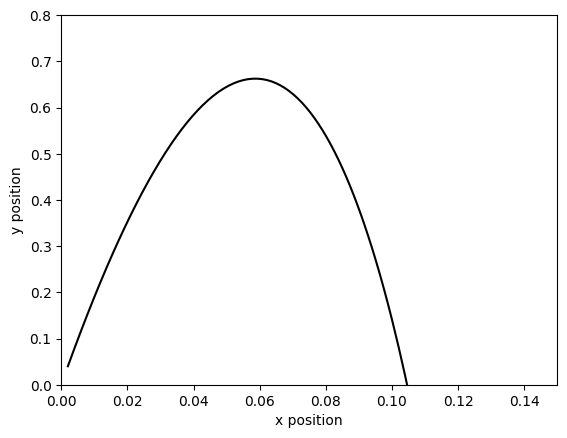

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.01 # in seconds
t_range = np.arange(0,2,dt)

g = 9.8
mass = 2.0
b = 1  # /s

def move(dt, xpos, xvel, zpos, zvel):
    xpos = xpos + xvel * dt
    zpos = zpos + zvel * dt
    zvel = zvel + (-g-b*zvel) * dt
    xvel = xvel + (-b*xvel) *dt
    return xpos, xvel, zpos, zvel

#initialize particle state
xpos=0
xvel=0.2
zpos=0
zvel=4.0
xn=[]
zn=[]

for t in t_range:
    xpos, xvel, zpos, zvel = move(dt, xpos, xvel, zpos, zvel)
    xn.append(xpos)
    zn.append(zpos)

fig, ax = plt.subplots(1)
ax.plot(xn,zn,'k-')
ax.set_xlim(0,0.15)
ax.set_ylim(0,0.8)
ax.set_ylabel('y position')
ax.set_xlabel('x position')
plt.show()

Now we'll implement the Runge-Kutta method at 2nd order. It's easier to work backwards, starting from what we need at the end: update every variable by their time derivative taken at the midpoint between t and t+dt.

### Stage 1: Compute accelerations at time $t$

At the start of each timestep, compute the acceleration from the current velocities.

- Horizontal: only drag acts, so $a_x = -b \cdot v_x$
- Vertical: both gravity and drag act, so $a_z = -g - b \cdot v_z$

Fill in the two lines below.

In [ ]:
# Stage 1: accelerations at current time t
# Hint: drag acceleration = -b * velocity; gravity adds -g to the vertical

xacc = -b*xvel   # horizontal acceleration (drag only)
zacc = -g-b*zvel    # vertical acceleration (gravity + drag)

### Stage 2: Estimate state at the midpoint $t + dt/2$

Use the Stage 1 accelerations to step each velocity forward by *half* a timestep, then recompute the accelerations at that midpoint state.

- $v_{x,\text{half}} = v_x + a_x \cdot dt/2$
- Recompute $a_{x,\text{half}} = -b \cdot v_{x,\text{half}}$
- Same pattern for $z$

Fill in the four lines below.

In [ ]:
# Stage 2: estimate state at midpoint t + dt/2
# Hint: step velocity forward by half a timestep using the Stage 1 acceleration,
#        then recompute acceleration from that midpoint velocity.

xvel_half = xvel + xacc * dt/2   # x-velocity at midpoint
xacc_half = -b*xvel_half                  # x-acceleration at midpoint
zvel_half = zvel + zacc * dt/2                 # z-velocity at midpoint
zacc_half = -g-b*zvel_half                # z-acceleration at midpoint (gravity + drag)

### Stage 3: Advance from $t$ to $t + dt$ using midpoint slopes

Now use the midpoint velocities and accelerations (from Stage 2) to take the full step.

- Position update uses **midpoint velocity**: $x = x + v_{x,\text{half}} \cdot dt$
- Velocity update uses **midpoint acceleration**: $v_x = v_x + a_{x,\text{half}} \cdot dt$
- Same pattern for $z$

Fill in the four lines below.

In [ ]:
# Stage 3: full step from t to t+dt using midpoint slopes
# Hint: use the _half variables from Stage 2, not the original velocities/accelerations.

xpos = xpos + xvel_half * dt    # x-position: use x-velocity at midpoint
xvel = xvel + xacc_half * dt    # x-velocity: use x-acceleration at midpoint
zpos = zpos + zvel_half * dt    # z-position: use z-velocity at midpoint
zvel = zvel + zacc_half * dt    # z-velocity: use z-acceleration at midpoint

### Putting it all together

Now assemble your three stages into a complete `move_RK2` function. Fill in all the blanks — you've already worked out each piece above.

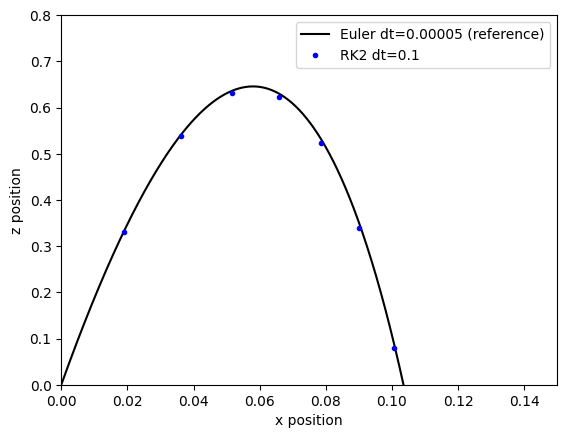

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dt_ref = 0.00005  # tiny dt for Euler reference solution
t_range = np.arange(0, 2, dt_ref)
g = 9.8
mass = 10
b = 1  # /s

# Euler's method — complete; use this as your reference
def move_Euler(xpos, xvel, zpos, zvel):
    xpos = xpos + xvel * dt_ref
    zpos = zpos + zvel * dt_ref
    zvel = zvel + (-g - b*zvel) * dt_ref
    xvel = xvel + (-b*xvel) * dt_ref
    return xpos, xvel, zpos, zvel

# TODO: fill in every blank to complete the RK2 integrator.
def move_RK2(xpos, xvel, zpos, zvel, dt):
    # --- Stage 1: accelerations at time t ---
    xacc = -b* xvel
    zacc = -g-b* zvel

    # --- Stage 2: midpoint estimates at t + dt/2 ---
    xvel_half = xvel + xacc * dt/2
    xacc_half = -b* xvel_half
    zvel_half = zvel + zacc * dt/2
    zacc_half = -g-b* zvel_half

    # --- Stage 3: full step using midpoint slopes ---
    xpos = xpos + xvel_half * dt
    xvel = xvel + xacc_half * dt
    zpos = zpos + zvel_half * dt
    zvel = zvel + zacc_half * dt
    return xpos, xvel, zpos, zvel

# --- Run Euler reference ---
xpos=0; xvel=0.2; zpos=0; zvel=4.0
xn=[]; zn=[]
for t in t_range:
    xpos, xvel, zpos, zvel = move_Euler(xpos, xvel, zpos, zvel)
    if zpos < 0:
        break
    xn.append(xpos); zn.append(zpos)

# --- Run RK2 with large timestep ---
dt_rk2 = 0.1
xpos=0; xvel=0.2; zpos=0; zvel=4.0
xr=[]; zr=[]
t = 0.0
while t < t_range[-1]:
    xpos, xvel, zpos, zvel = move_RK2(xpos, xvel, zpos, zvel, dt_rk2)
    if zpos < 0:
        break
    xr.append(xpos); zr.append(zpos)
    t += dt_rk2

fig, ax = plt.subplots(1)
ax.plot(xn, zn, 'k-', label='Euler dt=0.00005 (reference)')
ax.plot(xr, zr, 'b.', label='RK2 dt=0.1')
ax.set_xlim(0, 0.15); ax.set_ylim(0, 0.8)
ax.set_ylabel('z position'); ax.set_xlabel('x position')
ax.legend()
plt.show()

Notice that the RK2 method solution (blue dots) is very accurate even though the timestep is HUGE ($dt=0.1$ seconds)! This demonstrates the much smaller error of the Runge-Kutta 2nd order method.

Demonstration of $O(dt^2)$ global error behavior:

At dt = 0.1 s,  error = 0.090-0.078 = 0.012m
At dt = 0.05 s,  error = 0.088-0.085 = 0.003m



This concludes version 1 of our RK2 code to simulate projectile motion.

### 🔬 Mini-Investigation: Verifying O(dt²) Error Scaling

The notebook above stated:
- At dt = 0.1 s: error ≈ 0.012 m
- At dt = 0.05 s: error ≈ 0.003 m

If global error scales as O(dt²), halving dt should reduce error by a factor of **4**.

**Your task:** Run `move_RK2` at three timesteps. Find the peak z-position (`max(zr)`) and compute the error relative to the Euler reference.

| dt (s) | Peak z_RK2 (m) | Error (m) | Error ratio (prev/current) |
|--------|---------------|-----------|---------------------------|
| 0.1    |               |           | —                         |
| 0.05   |               |           |                           |
| 0.025  |               |           |                           |

Does the ratio confirm O(dt²) scaling? What ratio do you expect?

**Bonus:** Try the same experiment with Euler's method. What ratio do you see, and what does that tell you about its error order?

In [ ]:
# Mini-investigation: verify O(dt^2) error scaling
# Compare RK2 solutions at a fixed time t=0.5 s against the analytic solution.
#
# Analytic solution for z(t) with linear drag:
#   z(t) = (zvel0 + g/b)/b * (1 - exp(-b*t)) - g*t/b

import numpy as np

g = 9.8
b = 1.0
xvel0, zvel0 = 0.2, 4.0
t_target = 0.5

z_exact = (zvel0 + g/b) / b * (1 - np.exp(-b * t_target)) - g * t_target / b
print(f"Analytic z at t={t_target} s: {z_exact:.6f} m\n")

dts = [0.1, 0.05, 0.025]
errors = []

for dt_test in dts:
    xpos=0; xvel=xvel0; zpos=0; zvel=zvel0
    t = 0.0
    while t < t_target - 1e-10:
        xpos, xvel, zpos, zvel = move_RK2(xpos, xvel, zpos, zvel, dt_test)
        t += dt_test
    error = zpos - z_exact
    errors.append(error)
    print(f"dt = {dt_test:.3f} s | z = {zpos:.6f} m | error = {error:.2e} m")

print("\nConvergence ratios (expect ~4 for RK2):")
for i in range(1, len(dts)):
    ratio = errors[i-1] / errors[i]
    print(f"  dt={dts[i-1]} -> dt={dts[i]}: ratio = {ratio:.3f}")

Analytic z at t=0.5 s: 0.529877 m

dt = 0.100 s | z = 0.522354 m | error = -7.52e-03 m
dt = 0.050 s | z = 0.528066 m | error = -1.81e-03 m
dt = 0.025 s | z = 0.529433 m | error = -4.44e-04 m

Convergence ratios (expect ~4 for RK2):
  dt=0.1 -> dt=0.05: ratio = 4.155
  dt=0.05 -> dt=0.025: ratio = 4.076


In [ ]:
import numpy as np

g = 9.8
b = 1.0
xvel0, zvel0 = 0.2, 4.0
t_target = 0.5

z_exact = (zvel0 + g/b) / b * (1 - np.exp(-b * t_target)) - g * t_target / b
print(f"Analytic z at t={t_target} s: {z_exact:.6f} m\n")

dts = [0.1, 0.05, 0.025]
errors = []

for dt_test in dts:
    xpos=0; xvel=xvel0; zpos=0; zvel=zvel0
    t = 0.0
    while t < t_target - 1e-10:
        xpos, xvel, zpos, zvel = move_Euler(xpos, xvel, zpos, zvel)
        t += dt_test
    error = zpos - z_exact
    errors.append(error)
    print(f"dt = {dt_test:.3f} s | z = {zpos:.6f} m | error = {error:.2e} m")

print("\nConvergence ratios (Euler):")
for i in range(1, len(dts)):
    ratio = errors[i-1] / errors[i]
    print(f"  dt={dts[i-1]} -> dt={dts[i]}: ratio = {ratio:.3f}")

Analytic z at t=0.5 s: 0.529877 m

dt = 0.100 s | z = 0.001000 m | error = -5.29e-01 m
dt = 0.050 s | z = 0.001998 m | error = -5.28e-01 m
dt = 0.025 s | z = 0.003993 m | error = -5.26e-01 m

Convergence ratios (Euler):
  dt=0.1 -> dt=0.05: ratio = 1.002
  dt=0.05 -> dt=0.025: ratio = 1.004
